# 0.0. IMPORTS

In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import inflection
import math

from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image

import warnings 
warnings.filterwarnings("ignore")

## 0.1. Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 25
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#Função merge. Recebe como 1º Argumento o arquivo que vai ser a referencia, 2º o arquivo que será anexado a essa referencia. 
# on=Store é a coluna que faz a referencia nos dois arquivos
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')


In [5]:
# Exibe uma linha aleatoria
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
881334,155,4,2013-05-02,8948,810,1,1,0,0,d,a,3050.0,NaN,NaN,1,35.0,2010.0,"Jan,Apr,Jul,Oct"


# 1.0. PASSO 01 - DESCRIÇÃO DOS DADOS

In [6]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename

df1.columns = cols_new

In [8]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [9]:
# .shape é um método que printa linha e colunas de um dataframe. No caso abaixo [0] representa as linhas e [1] as colunas
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types

In [10]:
# Convetendo object para data
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [12]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month 
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#competition_open_since_year  
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

#promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#promo_interval
# Esse dicionário substitui o número pelo mês...ex: 01 por Jan
month_map = { 1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov' ,12: 'Dec' }

df1['promo_interval'].fillna(0, inplace=True) # inplace=True não retorna nenhum valor, faz a modifição direto na coluna

# dt.month.map = A coluna date(ano,mês,dia) será transformada em data e depois em mês e será mapeado o month_map para que os numeros sejam substituido pelas letras. Vai mapear o dicionario dentro da coluna
df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )


In [13]:
df1.sample(5).T

,854295,1000793,609685,446594,72201
store,991,309,566,265,842
day_of_week,1,2,3,2,4
date,2013-05-27 00:00:00,2013-01-15 00:00:00,2014-01-01 00:00:00,2014-05-27 00:00:00,2015-05-28 00:00:00
sales,6707,4202,0,4199,16288
customers,585,437,0,473,956
open,1,1,0,1,1
promo,1,0,0,0,0
state_holiday,0,0,a,0,0
school_holiday,0,0,1,0,1
store_type,a,d,a,a,d


In [14]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [16]:
# Fazendo a conversão de float para int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' )


In [17]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [18]:
# Separando as variaveis numericas e categoricas
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'] )

In [19]:
num_attributes.sample(5)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
492237,193,3,8464,1167,1,1,1,520.0,4,2014,0,16,2014,0
356765,846,1,7866,917,1,0,0,8860.0,4,2004,1,37,2009,0
755125,1056,6,2379,295,1,0,0,5350.0,8,2013,1,40,2012,0
114956,112,7,0,0,0,0,0,1630.0,9,2009,0,16,2015,0
277435,1016,2,4629,436,1,0,0,550.0,11,2014,1,35,2010,0


In [20]:
cat_attributes.sample(5)

,state_holiday,store_type,assortment,promo_interval,month_map
669862,0,a,c,0,Nov
612520,0,d,c,"Mar,Jun,Sept,Dec",Dec
90237,0,d,a,0,May
121013,0,a,a,0,Apr
875740,0,a,c,"Feb,May,Aug,Nov",May


## 1.7.1 Numerical Attributes

In [21]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.mean ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenete
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()

#Renomeando as colunas
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.429727,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,3.998341,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5773.818972,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,633.145946,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,0.830107,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.381515,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.178647,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,5935.442677,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,6.786849,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2010.324840,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

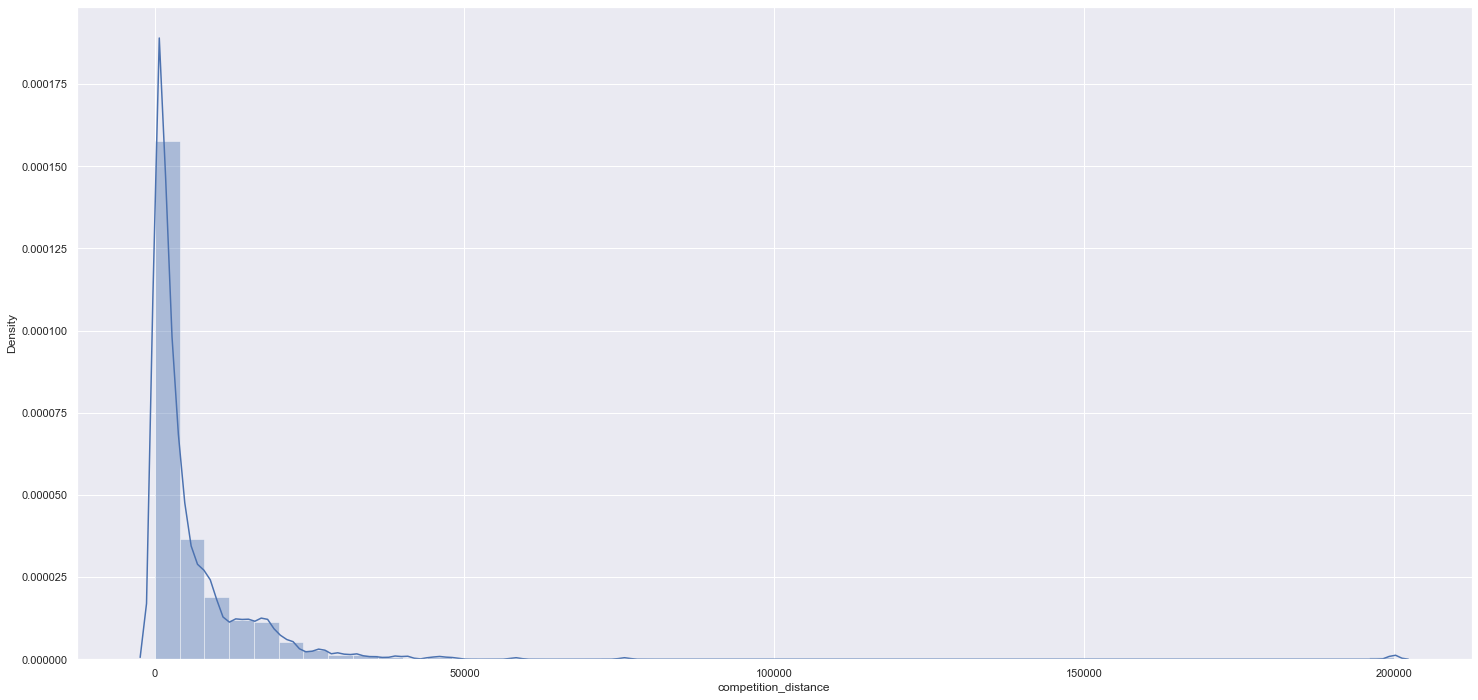

In [22]:
sns.distplot( df1['competition_distance'] )

## 1.7.2 Categorical Attributes

In [23]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

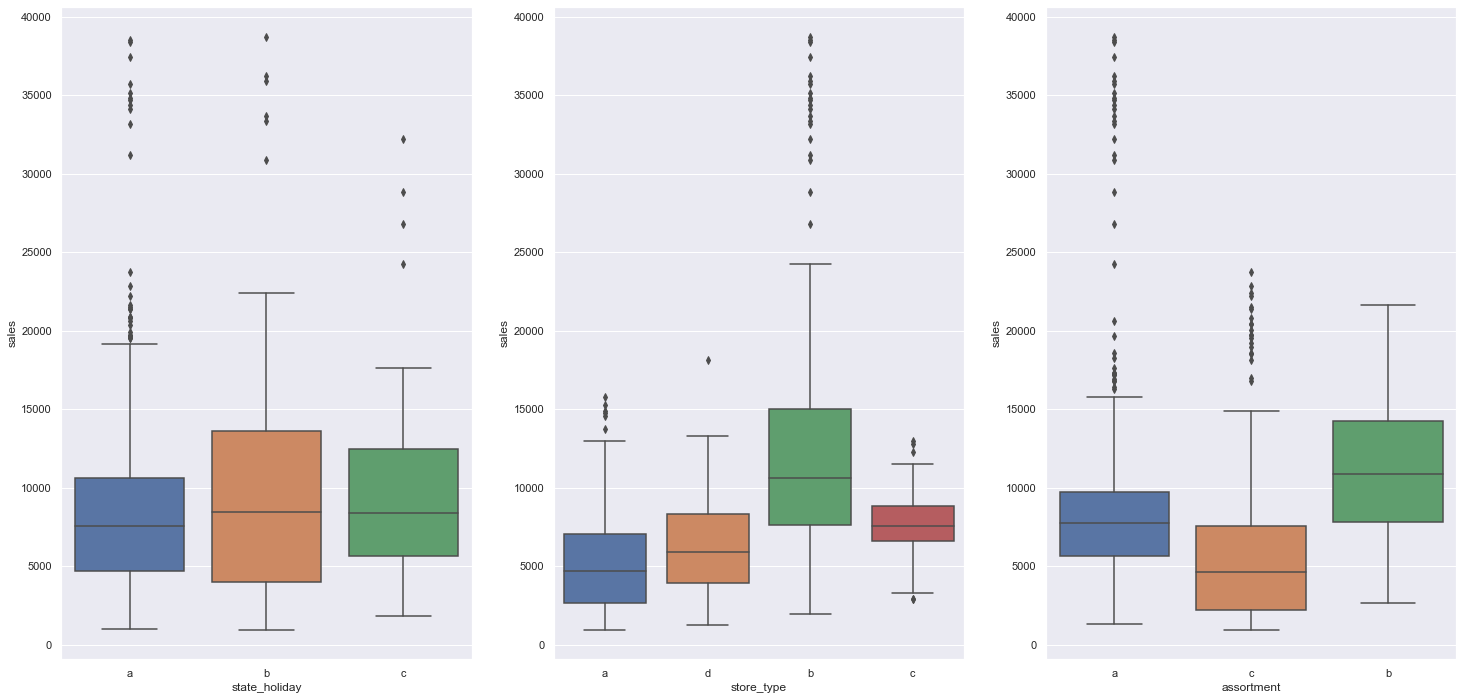

In [24]:
# O x é a linha de referencia o y o que quer ser medido 
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0 )]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux1 )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux1 )

# 2.0. PASSO 02 - FEATURE ENGINEERING

In [25]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses

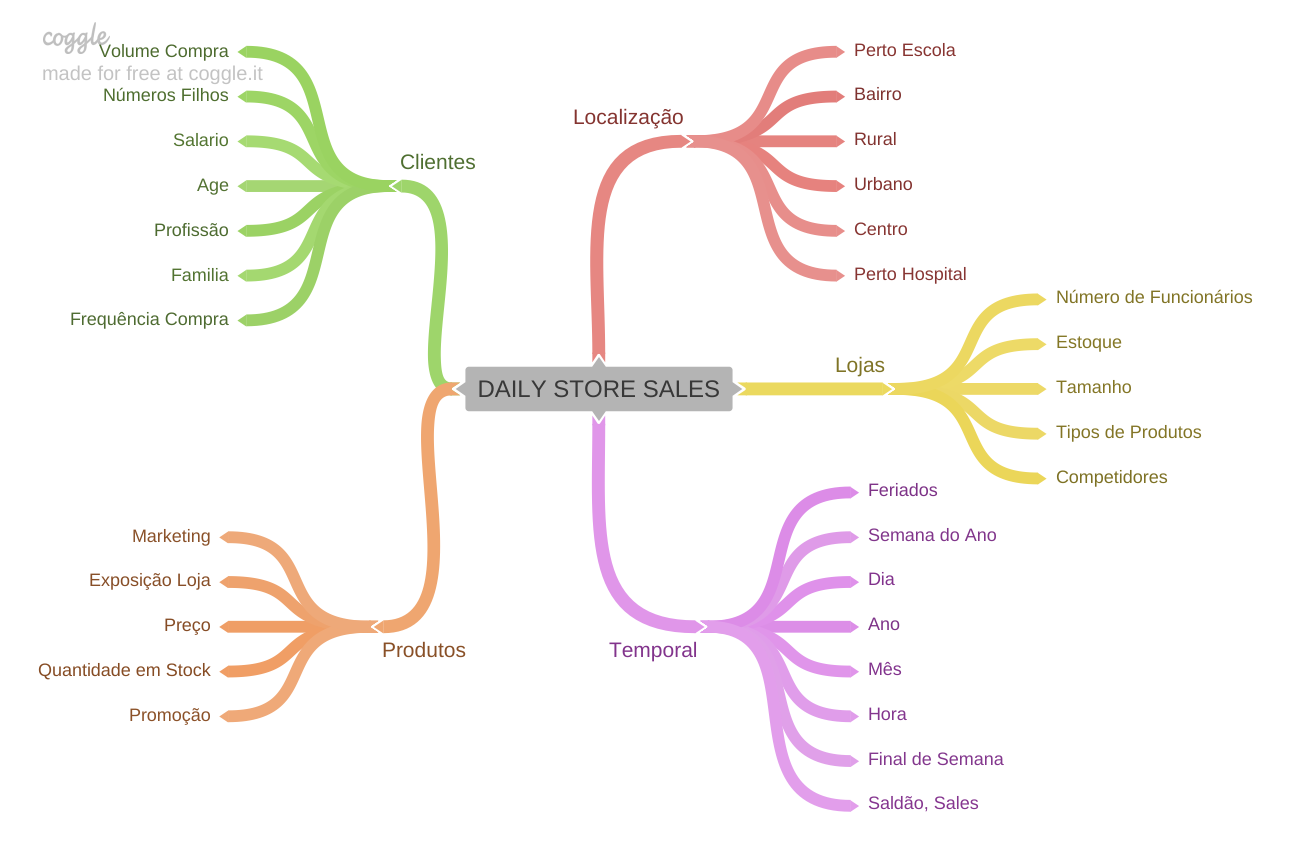

In [26]:
Image( 'img/MindMapHypothesis.png')

## 2.1. Criação das Hipóteses

### 2.1.1. Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.1.2. Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3. Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2. Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Feature Engineering

In [27]:
# year
df2['year'] = df2['date'].dt.year

## month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

In [28]:
# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

In [29]:
# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

In [30]:
# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x== 'b' else 'extended' )

In [31]:
# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [32]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [33]:
df3 = df2.copy()

In [34]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem da Linhas

In [35]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção das Colunas

In [36]:
# axis=1 colunas
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

In [37]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. PASSO 04 - ANALISE EXPLORATORIA DOS DADOS

In [38]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

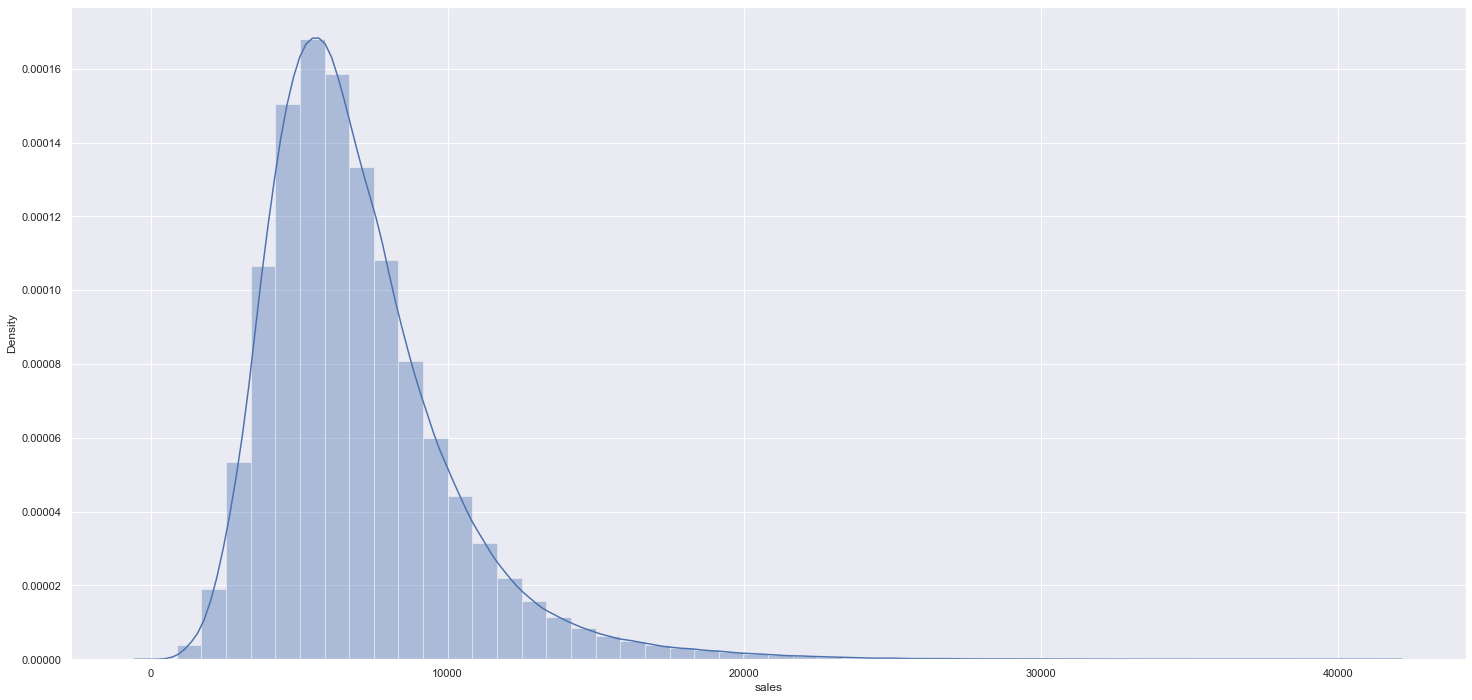

In [39]:
sns.distplot(df4['sales'])

### 4.1.2. Numerical Variable

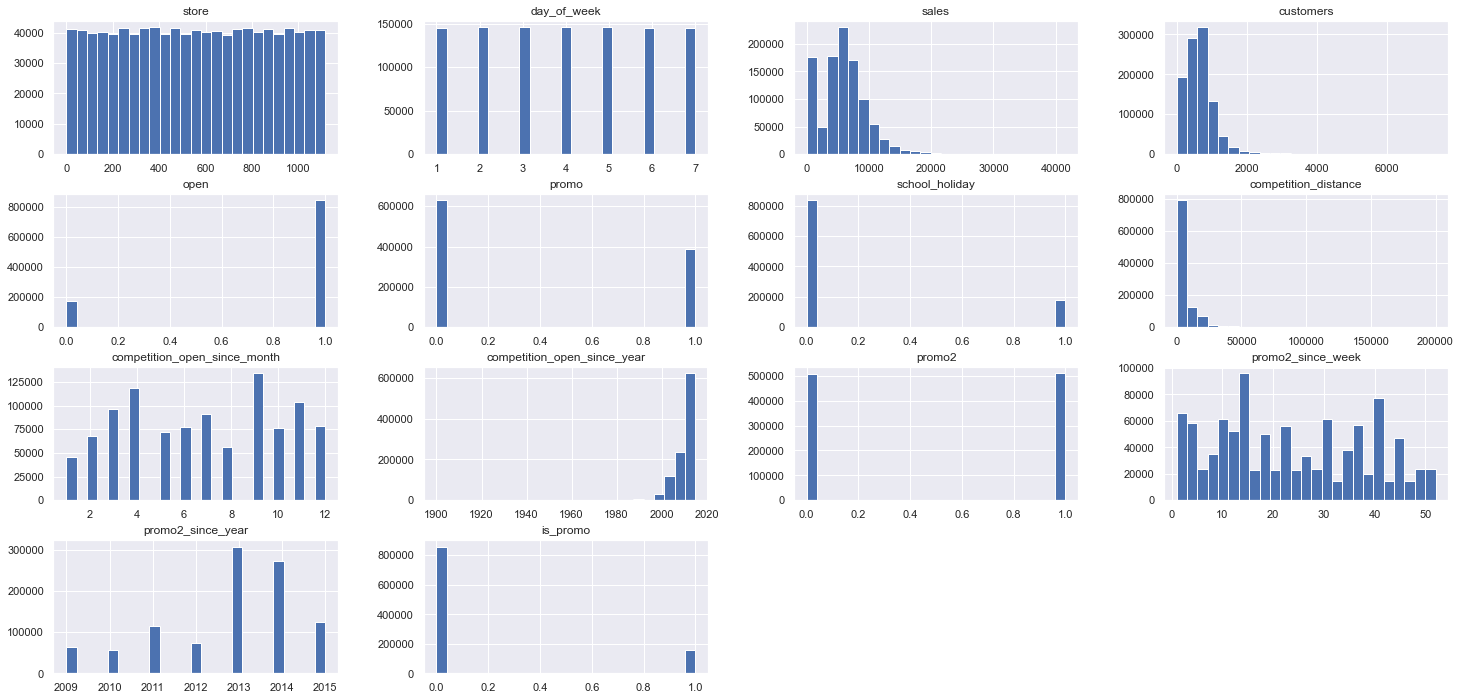

In [40]:
num_attributes.hist(bins=25);

### 4.1.3. Categorical Variable

In [41]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

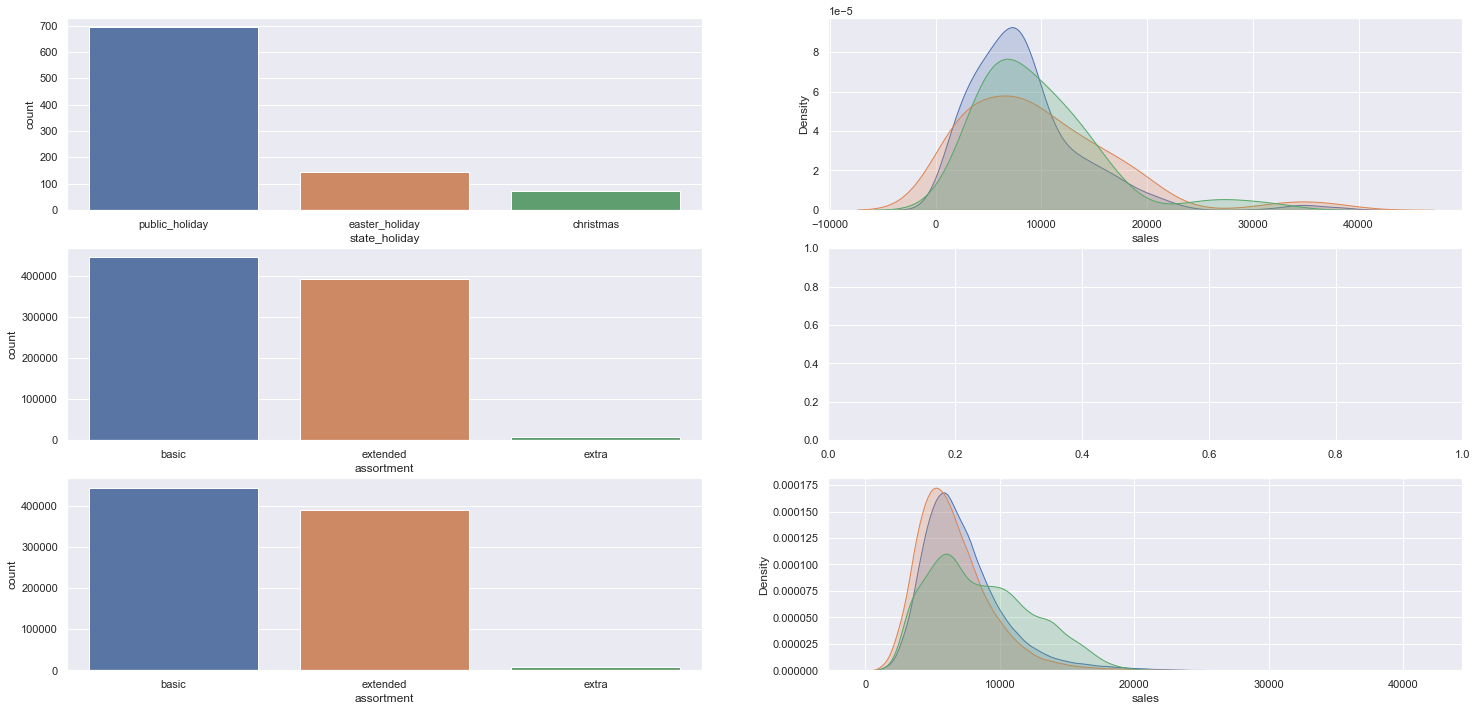

In [42]:
# state_holiday
plt.subplot( 3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2)
#shade = é pra deixar mais transparente
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

# assortment
plt.subplot( 3, 2, 3)
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 4)
#shade = é pra deixar mais transparente
sns.kdeplot( df4[df4['assortment'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'd']['sales'], label='d', shade=True)

# assortment
plt.subplot( 3, 2, 5)
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6)
#shade = é pra deixar mais transparente
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)


## 4.2. Analise Bivariada

### **H1.** Lojas com maior sortimentos deveriam vender mais.
**FALSA:** Lojas com MAIOR SORTIMENTO vendem MENOS.

<AxesSubplot:xlabel='year_week'>

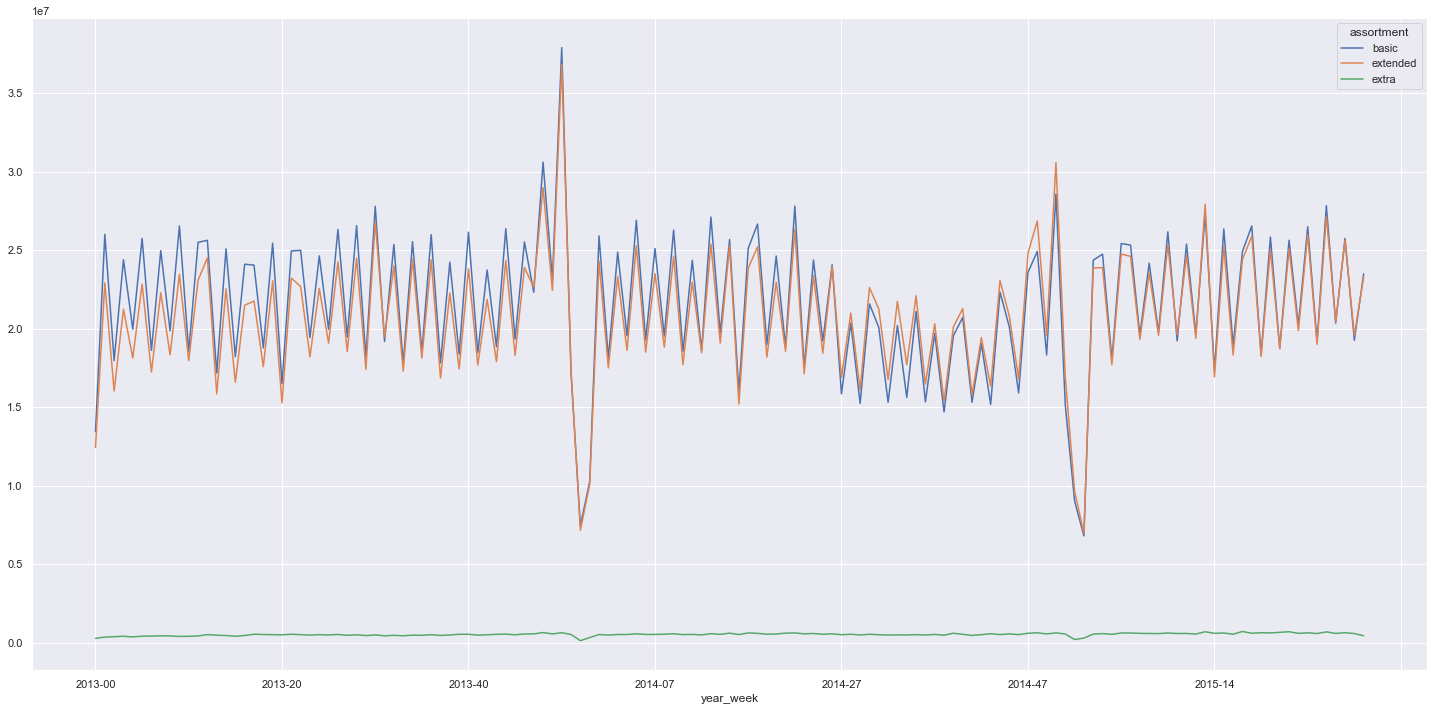

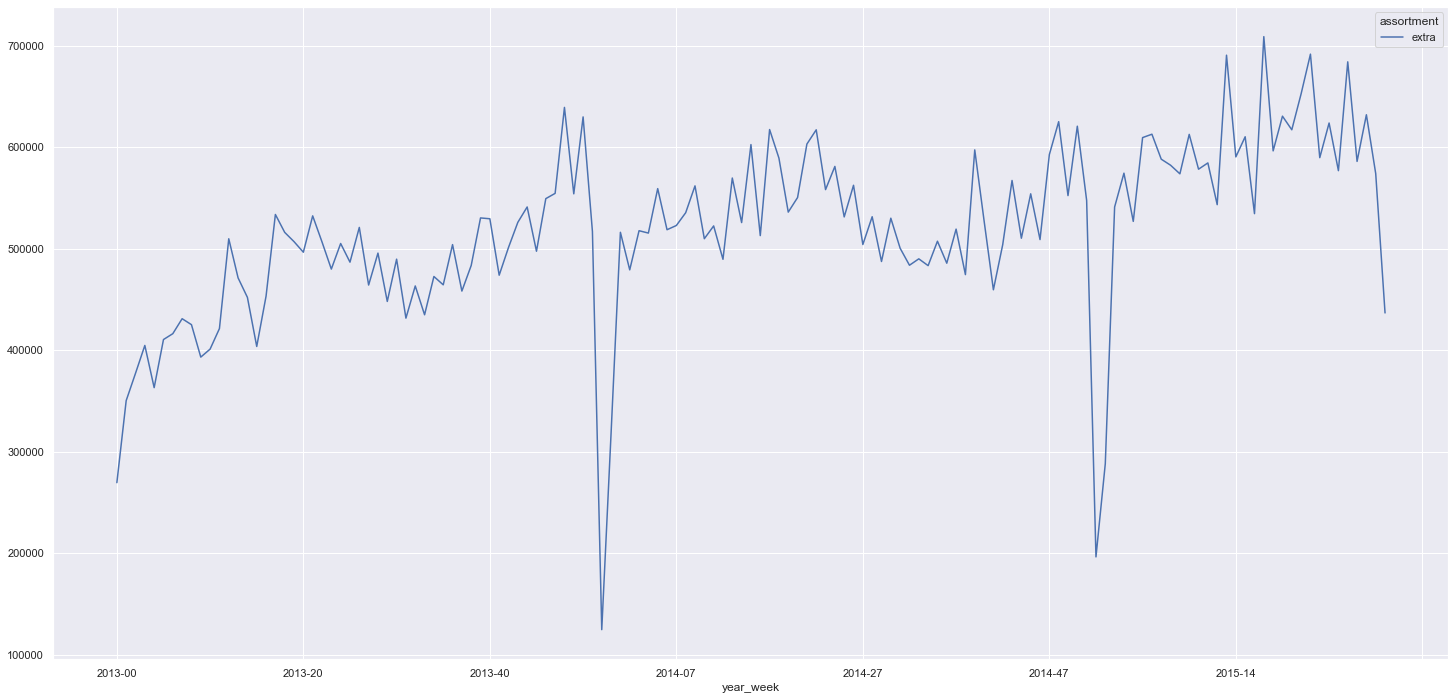

In [43]:
# reset_index é pra virar um DF para melhor visualização
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
#sns.barplot( x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()


aux2.pivot( index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales').plot()

In [44]:
aux3.head()

,year_week,assortment,sales
2,2013-00,extra,269404
5,2013-01,extra,350279
8,2013-02,extra,377207
11,2013-03,extra,404662
14,2013-04,extra,363061


### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSA:** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.

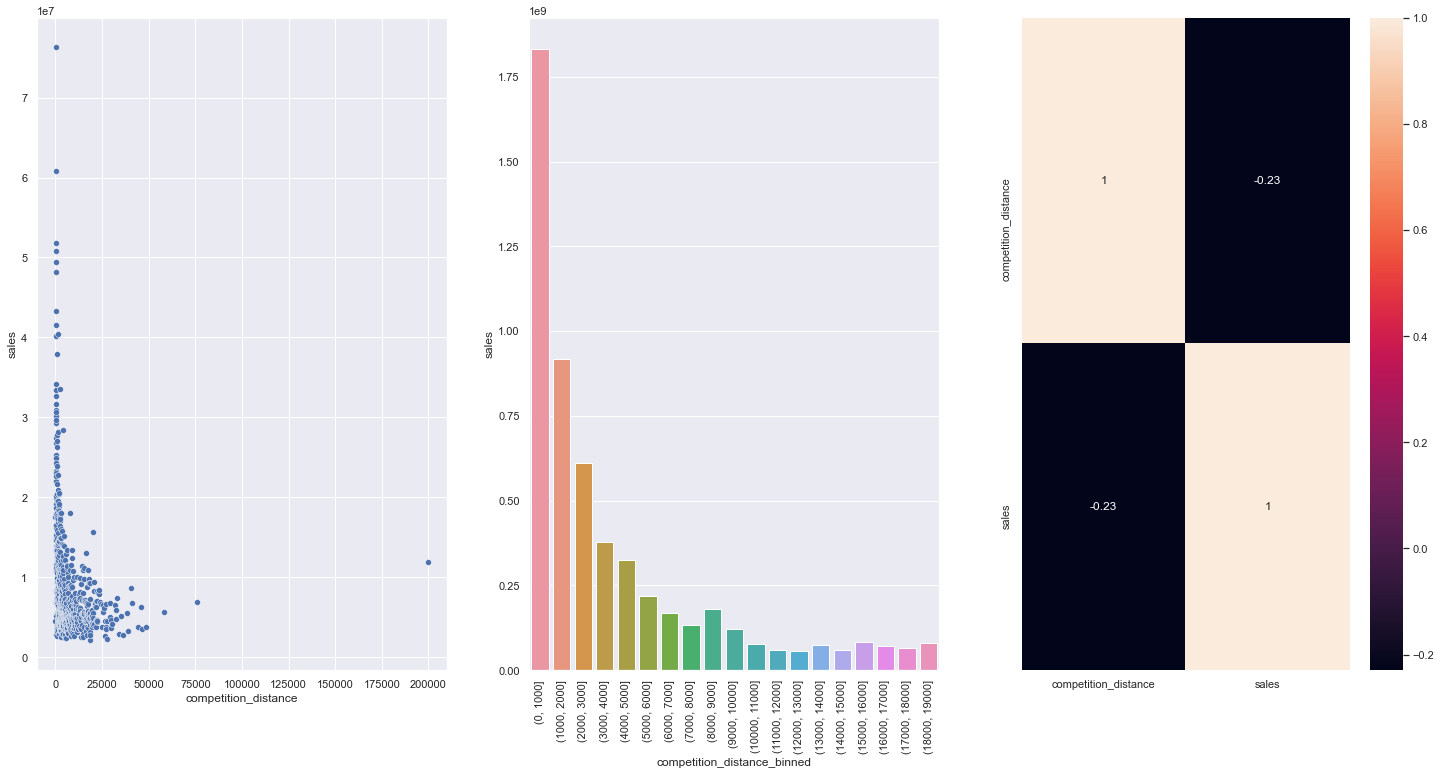

In [45]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot( 1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot( 1, 3, 2)
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks( rotation=90)

# Mede a força da correlação
plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True);


In [46]:
aux1.sample(5)

,competition_distance,sales,competition_distance_binned
20,220.0,29731168,"(0, 1000]"
35,370.0,10783867,"(0, 1000]"
530,13840.0,9118195,"(13000, 14000]"
577,18010.0,9819382,"(18000, 19000]"
26,280.0,16139643,"(0, 1000]"


### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.
**FALSA:** Lojas com COMPETIDORES Á MAIS TEMPO vendem MENOS.

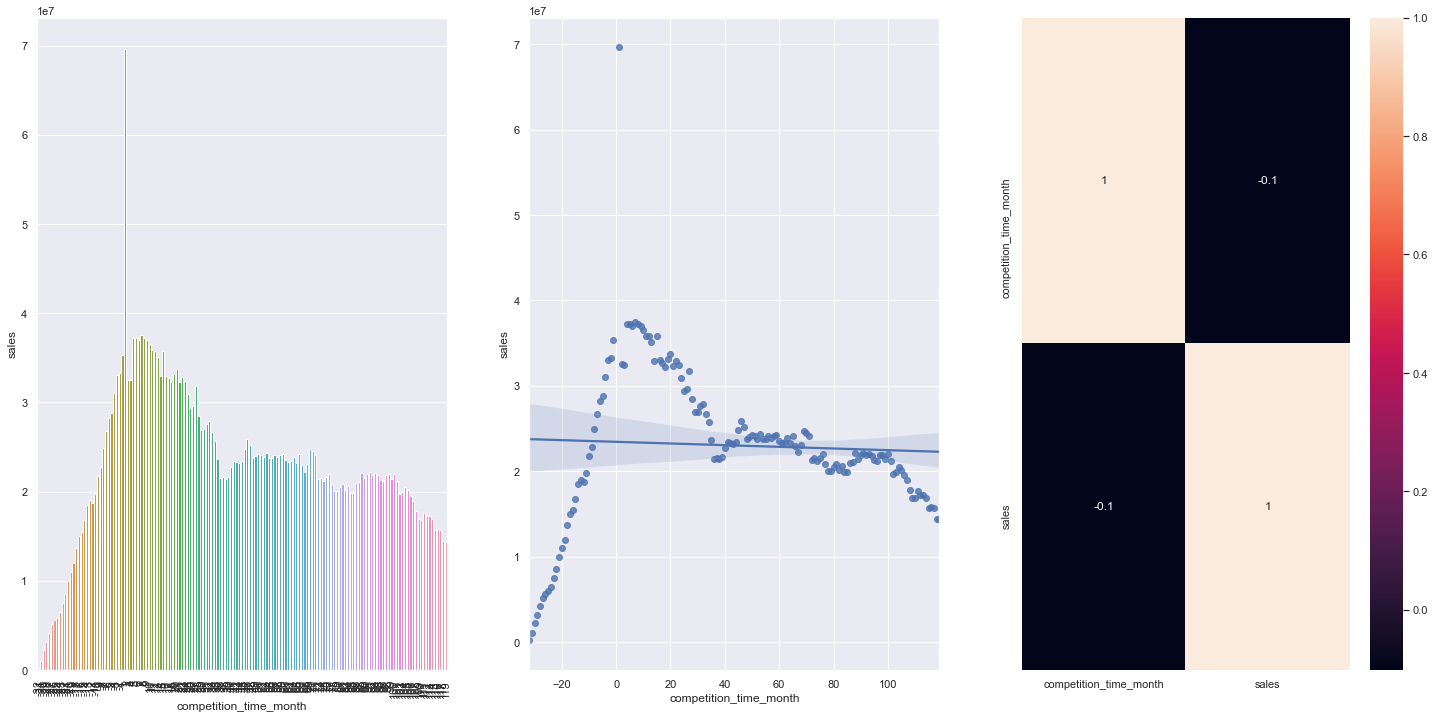

In [47]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 )]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks( rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr( method='pearson'), annot=True);


### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA:** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção.

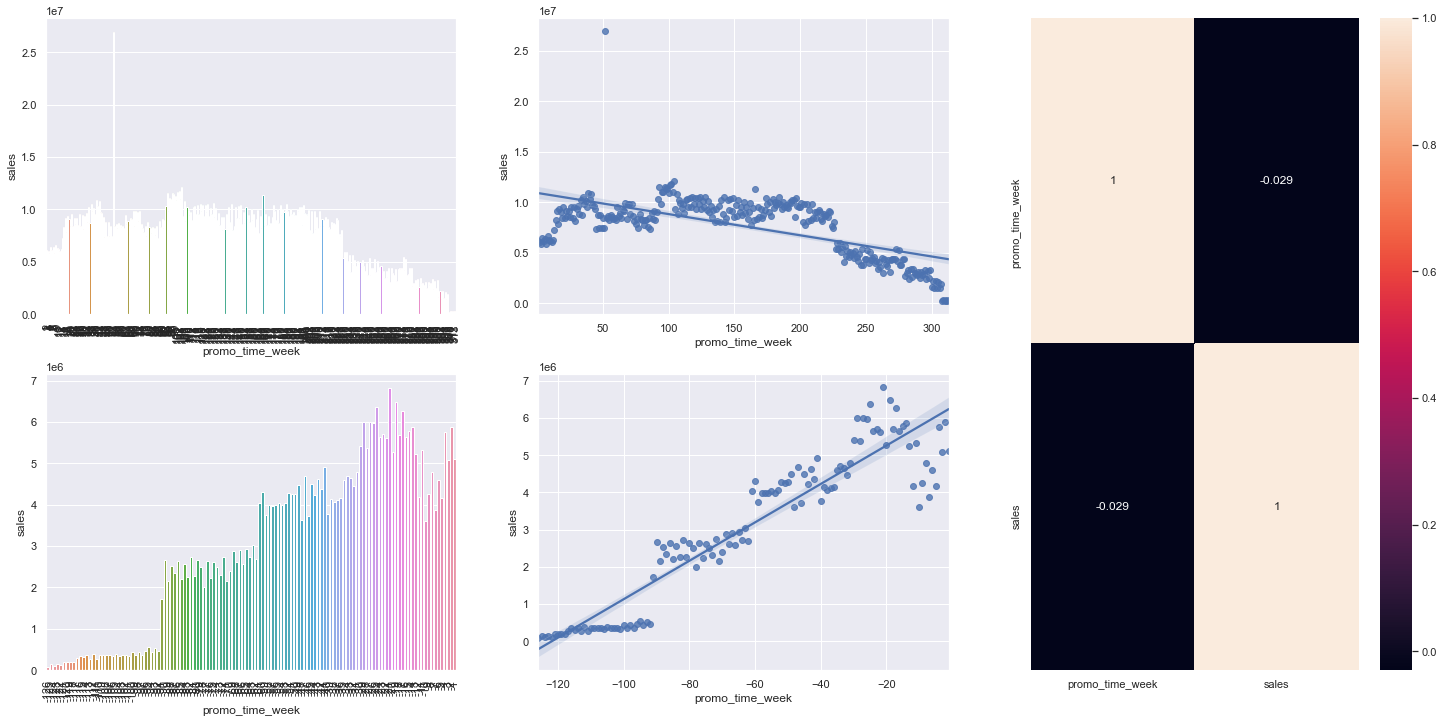

In [48]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2, 3) # faz o merge dos quadradinhos... 2 linhas 3 colunas

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendida
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks( rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks( rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap( aux1.corr(method='pearson'), annot=True ); # annot=True mostra os valores


### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>


### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA:** Lojas com mais promoções consecutivas vendem menos.

In [49]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


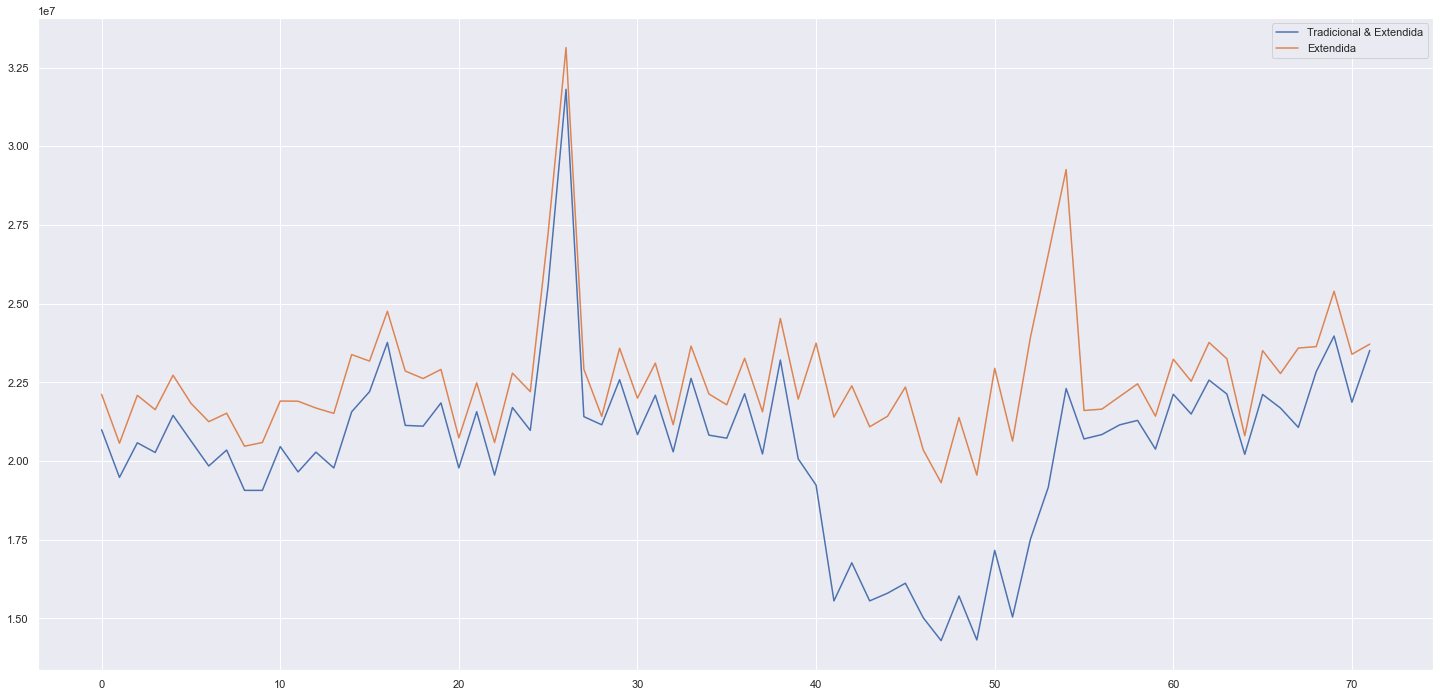

In [50]:
aux1 = df4[(df4['promo'] == 1 ) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1 ) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida'] );

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA:** Lojas abertas durante o feriado de Natal vendem MENOS.

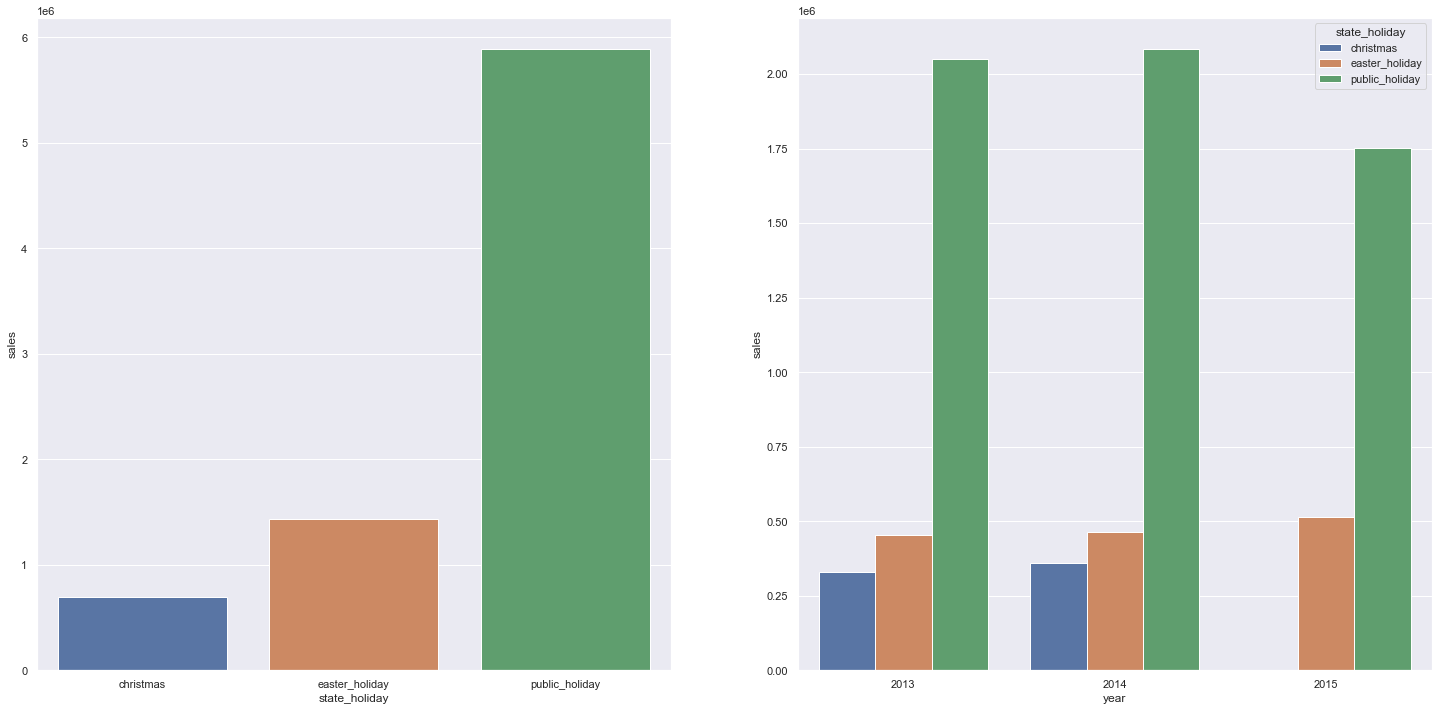

In [51]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2); # hue são os tipos de barras que quero no gráfico

### **H8.** Lojas deveriam vender mais ao longo dos anos.
**FALSA:** Lojas vendem MENOS ao longo dos anos

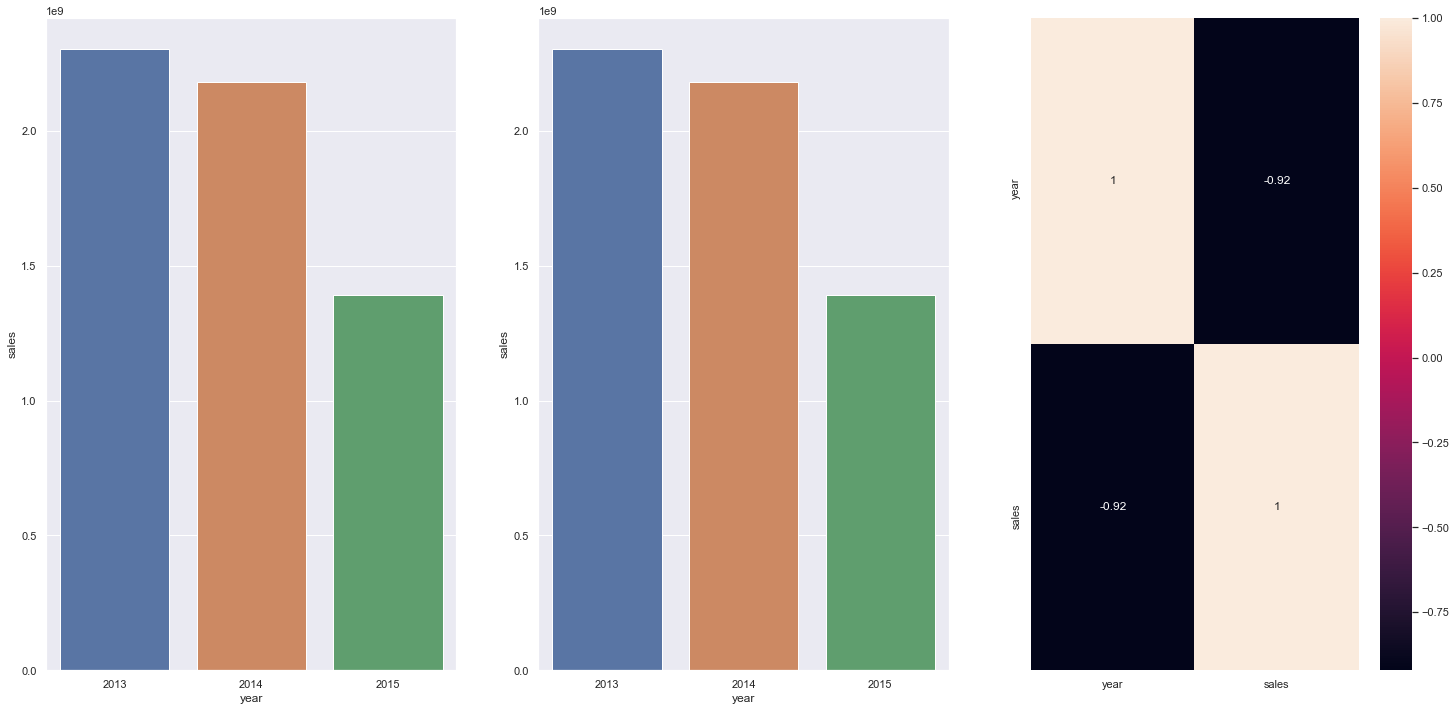

In [56]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1);

#Tendencia
plt.subplot(1, 3, 2)
sns.barplot(x='year', y='sales', data=aux1);

# Correlação
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True );

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSA:** Lojas vendem MENOS no segundo semestre do ano

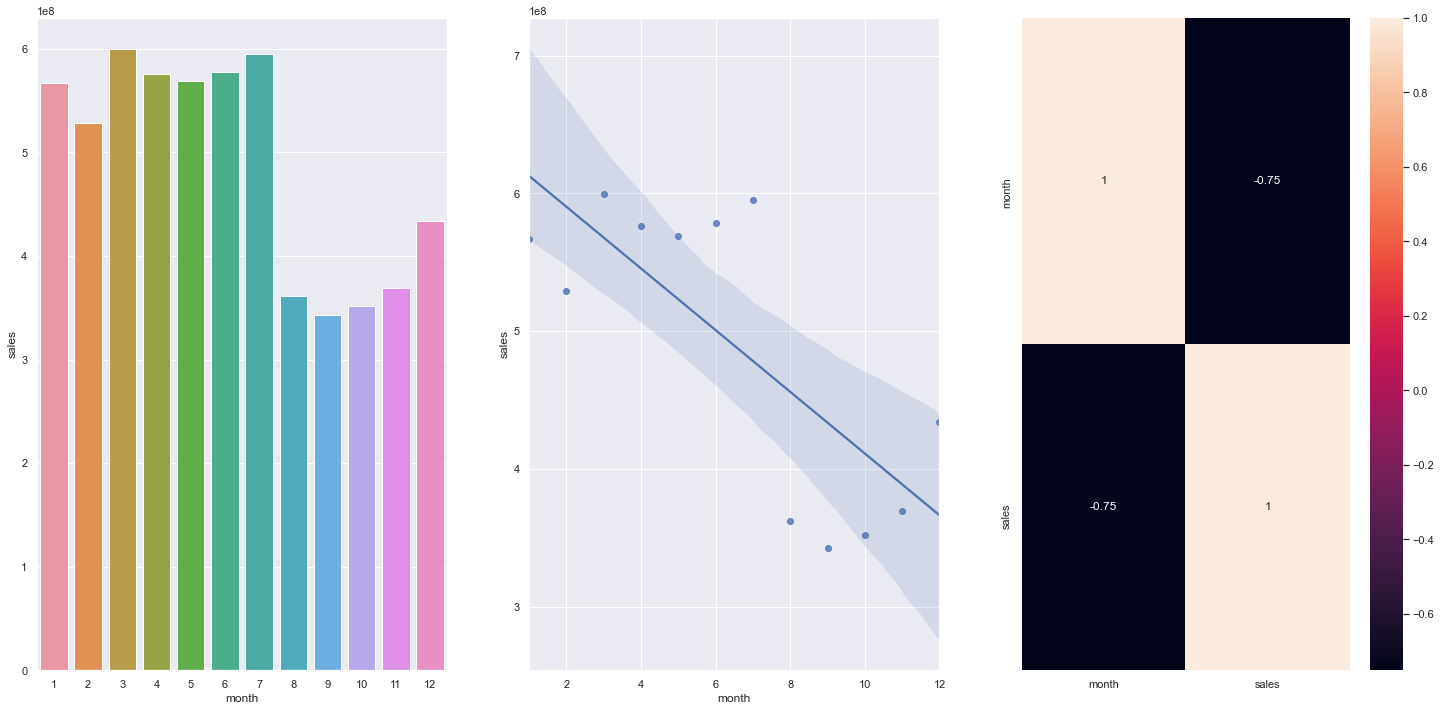

In [57]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA:** Lojas vendem MAIS depois do dia 10 de cada mês.

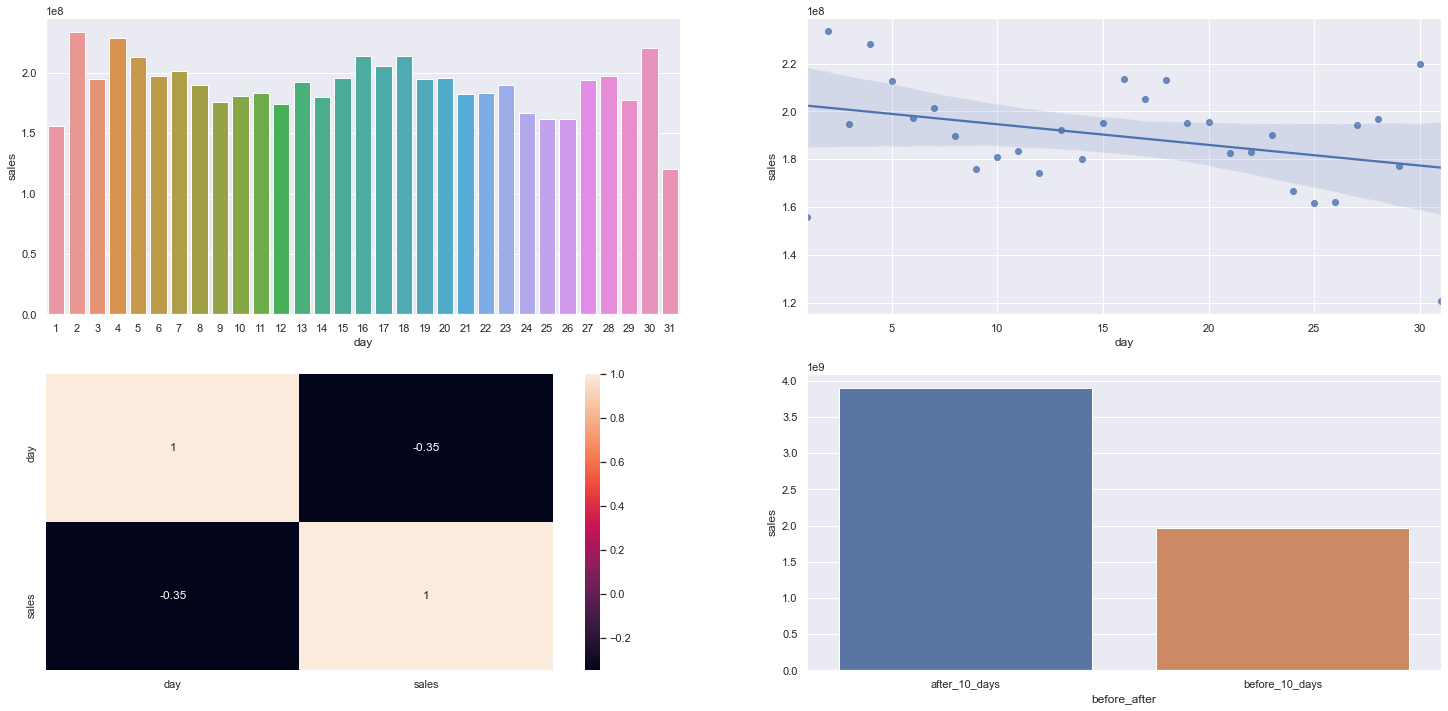

In [58]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

### **H11.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA:** Lojas vendem MENOS nos finais de semana;

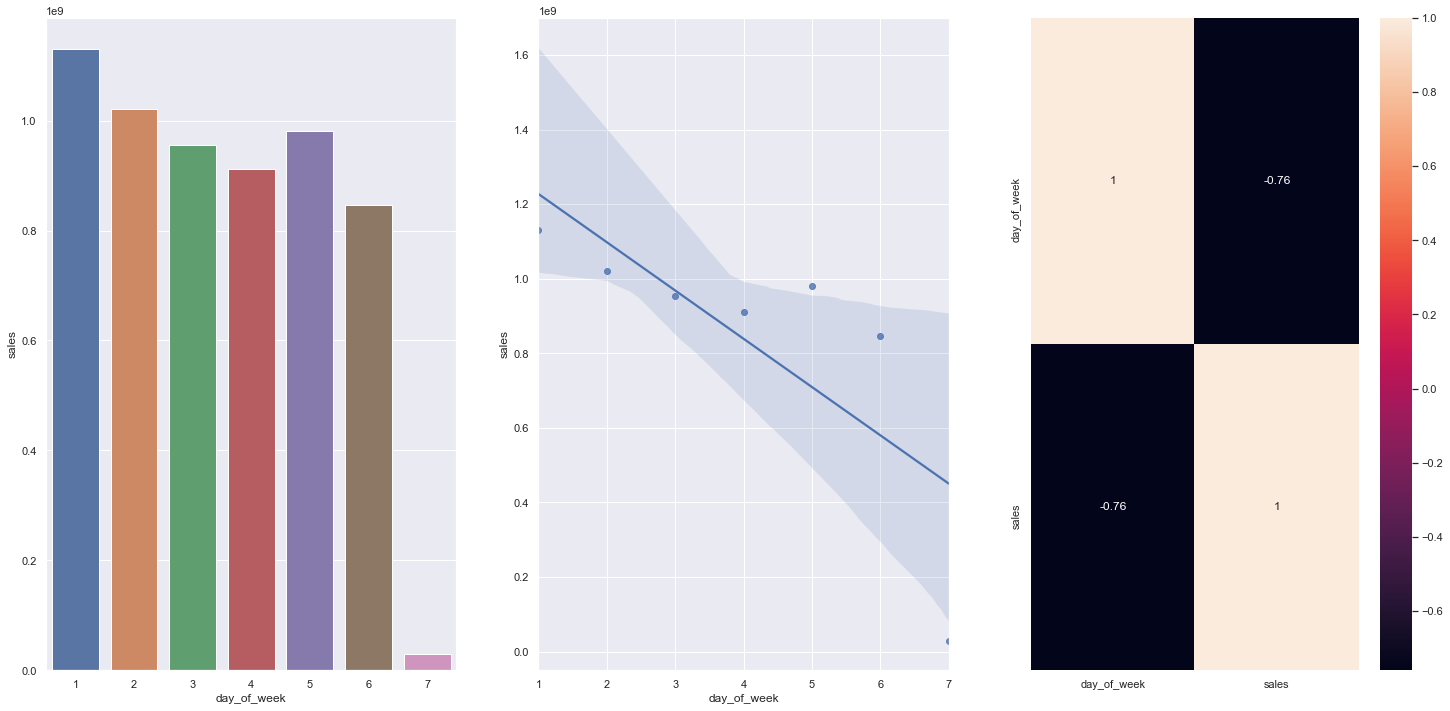

In [59]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H12.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA:** Lojas vendem menos durante os feriados escolares, exceto os meses de Julho e Agosto.

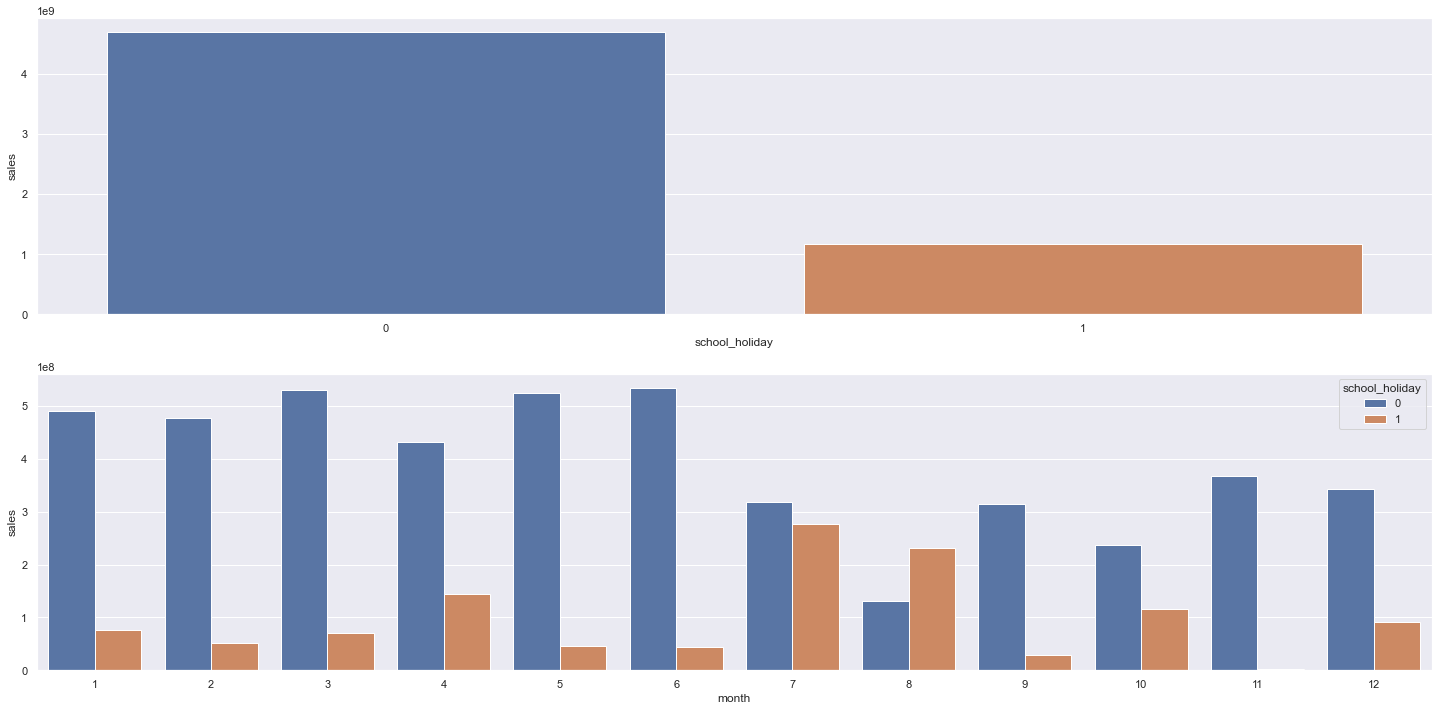

In [60]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

## 4.3. Analise Multivariada